In [74]:
import pandas as pd  
import collections
import numpy as np
from textblob import TextBlob # pip install -U textblob, python -m textblob.download_corpora
from textblob.classifiers import NaiveBayesClassifier
# import nltk # pip install nltk, python -m textblob.download_corpora
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline # pip install -q transformers
import matplotlib.pyplot as plt

# making dataframe
df = pd.read_csv("data/sentiment140_with_location.csv", names=['target','id','date','flag','user','text', 'location'])  

df

,target,id,date,flag,user,text,location
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",China
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Dominican Republic
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Germany
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Brazil
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Argentina
...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,Japan
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,Spain
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,Nigeria
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,Argentina


In [75]:
# split dataset
shuffled = df.sample(frac = 1)
result = np.array_split(shuffled, 8)
split_df = result[0]
split_df

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,target,id,date,flag,user,text,location
1183848,4,1982499184,Sun May 31 11:19:54 PDT 2009,NO_QUERY,poor_nana,@la_ri_sah tell them I said hi.,Argentina
458701,0,2071985087,Sun Jun 07 20:12:22 PDT 2009,NO_QUERY,NYStreetz,Damn it feels good to be back in the BX but I ...,Cuba
5840,0,1469213168,Tue Apr 07 05:37:49 PDT 2009,NO_QUERY,phrozen755,"@criana godspeed, I have one this Friday",Dominican Republic
248141,0,1982644468,Sun May 31 11:37:11 PDT 2009,NO_QUERY,LoFace,Charlie always makes fun of me,Dominican Republic
1484384,4,2067663298,Sun Jun 07 12:44:31 PDT 2009,NO_QUERY,MMCheviot,Having a great day. I'm definately blessed to...,USA
...,...,...,...,...,...,...,...
86678,0,1754197044,Sun May 10 05:22:32 PDT 2009,NO_QUERY,allieconrad,sigh. another eventing death RIP Bailey Wick ...,Nigeria
803949,4,1468448878,Tue Apr 07 01:44:11 PDT 2009,NO_QUERY,bread_abd,u donï¿½t know? (me too),South Africa
791850,0,2326088645,Thu Jun 25 06:32:03 PDT 2009,NO_QUERY,BrionyMayMcFly,@LucyBowen yeah but it was my birthday too. u...,Italy
1038732,4,1956716729,Thu May 28 22:30:47 PDT 2009,NO_QUERY,auntierah,can't believe school is done.....also can't be...,Italy


In [54]:
# tweets_by_location = collections.defaultdict(list)
# sentiment_sum = 0
# for row in df.iterrows():
#     sentiment = row[1][0]
#     text = row[1][5]
#     location = row[1][6]
#     sentiment_sum += sentiment
#     tweets_by_location[location].append(text)
# # print(tweets_by_location)
# print("average sentiment: ", sentiment_sum/df.size)

    

998994     @maxwellvintage I see twitter as a social part...
1580162    First 2 periods are freeee  don't have to go o...
587582        Why do they always find something else wrong? 
415282                               Watching a scary movie 
333772     @Shanicekarin i knooooooo. Omg I'm hungry. All...
                                 ...                        
1380201                         @AquaRuby sent you one back 
1597212    @timzero4 not so odd; my religion course in co...
700891     And it's time of the month. My weekend just is...
1203895                    is watching the MTV Movie Awards 
1499587    @lizzzzbeth  you will love it here. i promisee...
Name: text, Length: 6077, dtype: object


In [38]:
target_counts = collections.Counter(result[0]['target'])
location_counts = collections.Counter(result[0]['location'])
print("target counts: ", target_counts)
print("location_counts: ", location_counts)

target counts:  Counter({4: 100013, 0: 99987})
location_counts:  Counter({'Mexico': 6213, 'Ecuador': 6212, 'Jamaica': 6193, 'Thailand': 6193, 'South Korea': 6190, 'China': 6151, 'Canada': 6145, 'Ethiopia': 6142, 'Brazil': 6114, 'Italy': 6102, 'Argentina': 6099, 'Egypt': 6093, 'Russia': 6091, 'UK': 6091, 'Japan': 6088, 'Tanzania': 6069, 'Kenya': 6042, 'India': 6041, 'Spain': 6024, 'Indonesia': 6023, 'Germany': 6022, 'Peru': 6022, 'Australia': 6019, 'Antarctica': 6015, 'Cuba': 6004, 'Nigeria': 6004, 'USA': 5999, 'South Africa': 5991, 'Dominican Republic': 5967, 'Chile': 5920, 'France': 5920, 'Colombia': 5915, 'New Zealand': 5886})


In [76]:
def locationSentiment(data, location):
    """
    input: location is the input location of interest
    output: the average sentiment of the tweets for a location
    """
    # go through the dataframe filtered by location
    # get the average sentiment of the tweets in that location by getting sum and dividing by number of rows
    location_data = data[data["location"] == location]
    total_sentiment_value = sum(list(location_data["target"]))
    return total_sentiment_value/len(location_data)

def getLocationTweetsWithSentiment(data, location):
    tweets_with_sentiment = []
    location_data = data[data["location"] == location]
    for row in location_data.iterrows():
        sentiment = row[1]['target']
        text = row[1]['text']
        sentiment_for_classifier = ""
        if sentiment == 0:
            # negative
            sentiment_for_classifier = "neg"
        elif sentiment == 4:
            # positive
            sentiment_for_classifier = "pos"
        tweets_with_sentiment.append((text,sentiment_for_classifier))
    return tweets_with_sentiment

# print(locationSentiment(result[0], "China"))
tweets = getLocationTweetsWithSentiment(result[0], "China")
print(tweets)


[('@inmeofficial Cannot wait to hear the new music, love you guys ', 'pos'), ("@deadbiteback Just think of those imminent rowies, a five is surely on it's way ", 'pos'), ('We listenin to foreign exchange and I tell her its phonte from little brother and she say &quot;I aint kno he was a singin ass nigga&quot; ', 'neg'), ("@GlobalPatriot bad karma, bad juju, and redhead scorn. but I am sure the boils won't show for a while ", 'pos'), ("All those years ago when I didn't really know them. On the Infinity Land tour. Gutted to have missed that, looking back ", 'neg'), ('@Saturnnl All over the place! Hou van veel muziek! ;) Thanks! ', 'pos'), ('I just want it to be over ', 'neg'), ('So UP right now ', 'pos'), ('@MarkAlanLowry Time to wake up Mark!!  ', 'pos'), ('@iamgaberosales yes. but i sort of found them in your c-box. so thank anyway! ', 'pos'), ('Check this video out -- BEYONCE EGO REMIX FT KANYE WEST http://bit.ly/h7x4J &lt;&lt; i like Ye but  @songzyuuup shoulda ', 'neg'), ('@tlwest70

In [40]:
# find average sentiment for each location and store in location_scores
location_scores = {}

for (location, count) in location_counts.items():
    score = locationSentiment(result[0], location)
    location_scores[location] = score

# code sourced from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
sorted_location_scores = {k: v for k, v in sorted(location_scores.items(), key=lambda item: item[1])}
sorted_location_scores

{'Russia': 1.9602692497126908,
 'India': 1.967886111570932,
 'UK': 1.9707765555737975,
 'Cuba': 1.9760159893404396,
 'Egypt': 1.9819464959789923,
 'Chile': 1.9831081081081081,
 'Canada': 1.9840520748576078,
 'Thailand': 1.98482157274342,
 'Ethiopia': 1.9856724194073592,
 'Ecuador': 1.987765614938828,
 'Japan': 1.9894875164257555,
 'South Korea': 1.9896607431340871,
 'Nigeria': 1.9913391072618254,
 'Spain': 1.9913678618857902,
 'South Africa': 1.9949924887330996,
 'China': 1.9964233457974314,
 'Jamaica': 1.9970934926529953,
 'Germany': 2.001992693457323,
 'Tanzania': 2.002965892239249,
 'New Zealand': 2.00339789330615,
 'Italy': 2.006555227794166,
 'Dominican Republic': 2.009049773755656,
 'Australia': 2.012958963282937,
 'USA': 2.0156692782130357,
 'Indonesia': 2.016270961314959,
 'Peru': 2.016605778811026,
 'Mexico': 2.018348623853211,
 'Kenya': 2.019860973187686,
 'Colombia': 2.019949281487743,
 'France': 2.020945945945946,
 'Brazil': 2.0307491004252536,
 'Antarctica': 2.034912718204

In [41]:
# drop unnecessary columns
split_df = split_df.drop(['id', 'date', 'flag', 'user'], axis=1)

split_df

,target,text,location
621094,0,Ok so i'm starting to feel better- but it's St...,Russia
223443,0,@JammieAdams ok I was sooo looking fwd to toni...,Ecuador
597275,0,brown skin (u kno who u r) IM SORRY takemeback),Cuba
743487,0,Back in Holland,South Africa
1534307,4,@kmdevito LOL Love the Want Ad!,Jamaica
...,...,...,...
953374,4,"@ghrishy i know, right? i'm looking for fligh...",Brazil
476062,0,doesn't want to be alone,India
217882,0,What a great time to get sick,Antarctica
855419,4,Recovered from 4/20,Argentina


In [91]:
# Naive Bayes Classifier
dataset = getLocationTweetsWithSentiment(result[0], "China")
train = dataset[:int(0.8*len(dataset))] # change this so that its actually a train test split 
test = dataset[int(0.8*len(dataset)):]
cl = NaiveBayesClassifier(train) # train needs tuples of text and pos/neg
correct = 0
for text, sentiment in test:
    pred = cl.classify(text)
    correct += (pred == sentiment)
print(correct/len(test))


pos
neg
neg
neg
pos
neg
pos
pos
pos
neg
neg
pos
neg
neg
neg
pos
neg
neg
pos
neg
pos
neg
neg
pos
pos
pos
neg
pos
neg
neg
pos
pos
pos
neg
pos
neg
pos
pos
neg
pos
neg
neg
pos
pos
pos
pos
neg
pos
neg
neg
pos
neg
pos
pos
neg
pos
neg
neg
neg
neg
neg
pos
pos
neg
pos
pos
pos
neg
pos
neg
neg
neg
neg
neg
neg
pos
neg
neg
pos
pos
pos
neg
neg
neg
pos
pos
neg
pos
neg
neg
pos
neg
pos
pos
pos
neg
neg
neg
neg
pos
pos
neg
neg
pos
pos
pos
pos
pos
neg
neg
pos
neg
neg
neg
neg
pos
neg
neg
pos
pos
neg
neg
neg
neg
pos
neg
pos
neg
neg
neg
pos
pos
neg
pos
pos
neg
pos
pos
neg
neg
neg
neg
pos
pos
pos
pos
neg
pos
neg
neg
neg
pos
neg
neg
pos
neg
neg
pos
pos
neg
pos
pos
pos
neg
neg
neg
neg
pos
neg
pos
neg
pos
pos
pos
neg
neg
pos
pos
pos
neg
pos
neg
neg
neg
pos
pos
pos
pos
pos
neg
pos
neg
pos
pos
neg
neg
neg
neg
neg
neg
pos
neg
pos
pos
pos
pos
pos
pos
neg
pos
neg
pos
neg
pos
neg
pos
neg
neg
pos
pos
pos
pos
neg
neg
neg
pos
pos
neg
neg
pos
neg
pos
pos
neg
pos
neg
pos
neg
neg
neg
pos
pos
pos
neg
neg
neg
pos
neg
pos
neg


In [67]:
# nltk sentiment intensity analyzer model
# 51% accuracy

sia = SentimentIntensityAnalyzer()
correct = 0
neu_count = 0
for text, sentiment in test:
    sia_pred = sia.polarity_scores(text)
    if sia_pred["compound"] < 0:
        pred = "neg"
    elif sia_pred["compound"] > 0:
        pred = "pos"
    else:
        pred = "neu"
        neu_count += 1
    correct += (pred == sentiment)

print("accuracy:", correct/len(test))
print("neu %:", neu_count/len(test))


accuracy: 0.5174654752233956
neu %: 0.2688870836718115


In [82]:
# this takes a while to run (took 3 min for me)

# hugging face transformer model
# 50% accuracy
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

correct = 0
data = [text for text, sentiment in test]

results = specific_model(data)

print(results)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'POS', 'score': 0.8754462003707886}, {'label': 'NEG', 'score': 0.9244073033332825}, {'label': 'NEU', 'score': 0.8922299742698669}, {'label': 'NEU', 'score': 0.8935555219650269}, {'label': 'NEG', 'score': 0.5731695294380188}, {'label': 'POS', 'score': 0.9924760460853577}, {'label': 'POS', 'score': 0.9736436605453491}, {'label': 'POS', 'score': 0.9925202131271362}, {'label': 'NEG', 'score': 0.9797177910804749}, {'label': 'POS', 'score': 0.9003080725669861}, {'label': 'NEG', 'score': 0.8283810615539551}, {'label': 'NEU', 'score': 0.9112067222595215}, {'label': 'NEU', 'score': 0.6502399444580078}, {'label': 'POS', 'score': 0.966383159160614}, {'label': 'POS', 'score': 0.9136260151863098}, {'label': 'POS', 'score': 0.988743782043457}, {'label': 'NEG', 'score': 0.9828667044639587}, {'label': 'NEU', 'score': 0.9029674530029297}, {'label': 'NEU', 'score': 0.9719296097755432}, {'label': 'POS', 'score': 0.5150103569030762}, {'label': 'POS', 'score': 0.9882405996322632}, {'label': 'NEG

In [66]:
# calculations for above model
correct = 0
neu_count = 0
for i in range(len(results)):
    label = results[i]['label'].lower()
    sentiment = test[i][1]
    if label == 'neu':
        neu_count += 1
    correct += (pred == sentiment)

print("accuracy:", correct/len(test))
print("neu %:", neu_count/len(test))

accuracy: 0.503655564581641
neu %: 0.3013809910641755


things to note about dataset:
- no "0" or "neutral" labels



data clean up:

- remove links from tweets, something like:
tweets = [t.replace("://", "//") for t in nltk.corpus.twitter_samples.strings()]

- remove tweets that don't have a location


TODO: 
* Location sentiment scores
* bar graphs for sentiment by location


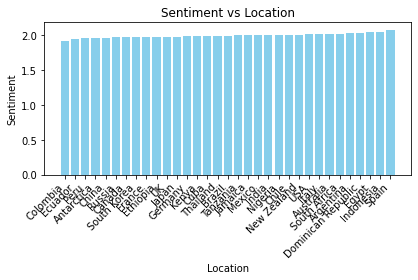

In [90]:
def plot_bar_graph(locations_with_sentiments):
    """
    input: locations with sentiments is a dictionary with the keys being the locations and the values is the sentiment
    """
    locations_list = list(locations_with_sentiments.keys())
    sentiment_list = list(locations_with_sentiments.values())

    # Plotting
    plt.bar(locations_list, sentiment_list, color='skyblue')
    plt.xlabel('Location')
    plt.ylabel('Sentiment')
    plt.title('Sentiment vs Location')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


# sorted_location_scores

plot_bar_graph(sorted_location_scores)

In [69]:
# only done for naive bayes so far
def averageSentimentByLocation(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    train = dataset[:int(0.8*len(dataset))] # change this so that its actually a train test split 
    test = dataset[int(0.8*len(dataset)):]
    # naive bayes
    naive_bayes = NaiveBayesClassifier(train)
    total_sentiment = 0
    for text, _ in test:
        pred = naive_bayes.classify(text)
        if pred == "pos":
            total_sentiment += 4
        if pred == "neu":
            total_sentiment += 2
        # negative is still just value 0
    average_sentiment = total_sentiment/len(test)
    return average_sentiment
    
averageSentimentByLocation('China')

1.8651502843216896

In [86]:
# SentimentIntensityAnalyzer (pre-trained)
def averageSentimentByLocation_sia(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    test = dataset[int(0.8*len(dataset)):]
    sia = SentimentIntensityAnalyzer()
    total_sentiment = 0
    # using test so we can compare scores across models
    for text, _ in test:
        sia_pred = sia.polarity_scores(text)
        if sia_pred["compound"] > 0:
            total_sentiment += 4
        elif sia_pred["compound"] == 0:
            total_sentiment += 2
    average_sentiment = total_sentiment/len(dataset)
    return average_sentiment

averageSentimentByLocation_sia('China')
    

0.4890887889388639

In [85]:
# hugging face transformer model (pre-trained)
def averageSentimentByLocation_hf(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
    # note: model can only take 204 or 128 items in dataset, so only using test
    data = [text for text, sentiment in test]
    results = specific_model(data)

    print(results)
    total_sentiment = 0
    for r in results:
        label = r['label'].lower()
        if label == 'pos':
            total_sentiment += 4
        if label == 'neu':
            total_sentiment += 2
    average_sentiment = total_sentiment/len(dataset)
    return average_sentiment

averageSentimentByLocation_hf('China')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'POS', 'score': 0.8754462003707886}, {'label': 'NEG', 'score': 0.9244073033332825}, {'label': 'NEU', 'score': 0.8922299742698669}, {'label': 'NEU', 'score': 0.8935555219650269}, {'label': 'NEG', 'score': 0.5731695294380188}, {'label': 'POS', 'score': 0.9924760460853577}, {'label': 'POS', 'score': 0.9736436605453491}, {'label': 'POS', 'score': 0.9925202131271362}, {'label': 'NEG', 'score': 0.9797177910804749}, {'label': 'POS', 'score': 0.9003080725669861}, {'label': 'NEG', 'score': 0.8283810615539551}, {'label': 'NEU', 'score': 0.9112067222595215}, {'label': 'NEU', 'score': 0.6502399444580078}, {'label': 'POS', 'score': 0.966383159160614}, {'label': 'POS', 'score': 0.9136260151863098}, {'label': 'POS', 'score': 0.988743782043457}, {'label': 'NEG', 'score': 0.9828667044639587}, {'label': 'NEU', 'score': 0.9029674530029297}, {'label': 'NEU', 'score': 0.9719296097755432}, {'label': 'POS', 'score': 0.5150103569030762}, {'label': 'POS', 'score': 0.9882405996322632}, {'label': 'NEG

0.45810428119273694